Устанавилваем все необходимые библиотеки и подключаем методы.


In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/Notebooks'

Mounted at /content/drive


In [2]:
pip install lime

     |████████████████████████████████| 276kB 4.2MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=221e9717bb55cfd1246bde2f4a7d099e2afdead1242274cad5b36e6e463eb62f
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [3]:
pip install shap

     |████████████████████████████████| 358kB 4.0MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491631 sha256=aa212060e2cca79045cd5cffc59946570518fac86ab2ee3ae4c2e6e289ef5156
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [4]:
pip install optuna


     |████████████████████████████████| 296kB 3.9MB/s 
     |████████████████████████████████| 174kB 17.4MB/s 
     |████████████████████████████████| 81kB 7.3MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 143kB 16.7MB/s 
     |████████████████████████████████| 112kB 17.3MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=52028e0cacedb69196f9668ebb3cd9f7b19477988931d1992d8e3d3a1167fb4d
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [5]:
pip install category_encoders

     |████████████████████████████████| 81kB 2.9MB/s 


In [6]:
pip install xgboost

In [7]:
pip install joblib

In [8]:
pip install catboost

     |████████████████████████████████| 67.3MB 55kB/s 


In [9]:
import sklearn
import sklearn.metrics
import numpy as np
import pandas as pd
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')
import os
import random
from optuna.samplers import TPESampler
import multiprocessing
import optuna
import pickle
from sklearn.utils import resample
from catboost import Pool
import catboost as cat
from optuna import create_study
from lightgbm import LGBMClassifier
import category_encoders
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import LabelEncoder
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
import joblib
from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
import lime 
import shap
from lime import lime_tabular
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from lime.lime_tabular import LimeTabularExplainer

Загрузка и предобработка исходных данных


In [10]:
data = pd.read_csv(path + '/train-2.csv')

In [11]:
y = data['TARGET']
X = data.drop(columns = 'TARGET')
X = X.drop(columns = 'SK_ID_CURR') 

In [12]:
submission = pd.read_csv(path + '/kaggle_test.csv')
ids = submission['SK_ID_CURR'].values
submission.drop('SK_ID_CURR', inplace=True, axis=1)


X_test = submission
#y_test = submission['TARGET']
#X_test = X_test.drop(columns = 'TARGET')

In [13]:
categorical = list(X.dtypes[X.dtypes == "object"].index)
for c, col in enumerate(X.columns):
   if ('FLAG' in col):
       categorical.append(col)
categorical += ['REG_REGION_NOT_LIVE_REGION',
               'REG_REGION_NOT_WORK_REGION',	'LIVE_REGION_NOT_WORK_REGION',	'REG_CITY_NOT_LIVE_CITY',	'REG_CITY_NOT_WORK_CITY',
               'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'b_Microloan', 'b_overdue_all',
               'b_overdue_Credit card', 'b_overdue_Consumer credit', 'b_overdue_Mortgage', 'b_overdue_Car loan', 'b_overdue_all_1',
               'b_overdue_Credit card_1', 'b_overdue_Consumer credit_1', 'b_overdue_Mortgage_1', 'b_overdue_Car loan_1', 'b_overdue_all_3', 
               'b_overdue_Credit card_3', 'b_overdue_Consumer credit_3', 'b_overdue_Mortgage_3', 'b_overdue_Car loan_3', 'p_is_several_a_day',
               'p_new_client_1', 'p_new_client_3', 'p_ins_ind']
numerical = list(set(X.columns) - set(categorical))


In [14]:
X[X == np.inf] = np.NaN
X_mean = X[numerical].mean()
X[numerical] = X[numerical].fillna(X_mean)
X[categorical] = X[categorical].fillna('-1')
for feature in categorical:
        le = LabelEncoder()
        le.fit(X[feature].astype('str'))
        X[feature] = le.transform(X[feature].astype('str'))

In [16]:
X_test_mean = X_test[numerical].mean()
X_test[numerical] = X_test[numerical].fillna(X_test_mean)
X_test[categorical] = X_test[categorical].fillna('-1')
for feature in categorical:
        le = LabelEncoder()
        le.fit(X_test[feature].astype('str'))
        X_test[feature] = le.transform(X_test[feature].astype('str'))

Подбор гиперпараметров для LightGBM, построение модели и ее интерпретации


In [ ]:
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
  train_x, test_x = X.iloc[train_index], X.iloc[test_index]
  train_y, test_y = y.iloc[train_index], y.iloc[test_index]
  def objective(trial):
    dtrain = lightgbm.Dataset(train_x, label=train_y, free_raw_data=False, categorical_feature = categorical)
 
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        "n_jobs":15
    }
 
    gbm = lightgbm.train(param, dtrain, categorical_feature = categorical)
    preds = gbm.predict(test_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(test_y, pred_labels)
    return accuracy
 
  study = create_study(direction='maximize')
  study.optimize(objective, n_trials=10)
 
  print('Number of finished trials:', len(study.trials))
  print('Best trial:', study.best_trial.params)

ModuleNotFoundError: ignored

In [17]:
clf = LGBMClassifier(boosting_type = 'gbdt',lambda_l1= 0.005459461026835422, lambda_l2= 9.608442070323532, num_leaves=54,
              feature_fraction= 0.43162004049719105, bagging_fraction = 0.5103866992880675, bagging_freq= 1, min_child_samples=59)
clf.fit(X,y,categorical_feature = categorical)
pred = clf.predict_proba(X_test)

ValueError: ignored

Отбор признаков

In [ ]:
a = clf.feature_importances_
a[a>15].size

107

In [ ]:
X_test = X_test.iloc[:,a>15]
X = X.iloc[:,a>15]

In [ ]:
correlated_features = set()
correlation_matrix = X.corr()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
X.drop(labels=correlated_features, axis=1, inplace=True)
X_test.drop(labels=correlated_features, axis=1, inplace=True)

X.shape, X_test.shape

((261384, 75), (48744, 75))

In [ ]:
rfe = RFE(clf, 30)
rfe = rfe.fit(X, y)

# summarize the selection of the attributes
print(rfe.support_)

# summarize the ranking of the attributes
fea_rank_ = pd.DataFrame({'cols':X.columns, 'fea_rank':rfe.ranking_})
fea_rank_.loc[fea_rank_.fea_rank > 0].sort_values(by=['fea_rank'], ascending = True)

[False  True  True  True False False False  True  True  True  True  True
 False  True False False  True  True  True  True False False False  True
 False False False False False False  True False  True  True False  True
  True  True False  True  True  True  True  True False False False False
  True False  True  True  True False False  True False False False False
 False False False False False False False False False False False False
 False False False]


,cols,fea_rank
37,b_all_avg,1
19,EXT_SOURCE_3,1
48,p_sum3,1
42,b_start_Consumer credit_avg,1
23,DAYS_LAST_PHONE_CHANGE,1
...,...,...
73,p_prod_group_POS industry_percent,42
24,FLAG_DOCUMENT_3,43
74,p_new_client_3,44
4,NAME_INCOME_TYPE,45


In [ ]:
k = np.array(fea_rank_.iloc[0:30,0])

In [15]:
k = ['CODE_GENDER', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'LANDAREA_AVG', 'APARTMENTS_MODE',
       'YEARS_BEGINEXPLUATATION_MEDI', 'DAYS_LAST_PHONE_CHANGE',
       'FLAG_DOCUMENT_3', 'b_closed_Consumer credit_num',
       'b_active_all_num', 'b_Consumer credit_sum_1', 'b_all_sum_1',
       'b_Credit card_sum_3']
k

['CODE_GENDER',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'LANDAREA_AVG',
 'APARTMENTS_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'b_closed_Consumer credit_num',
 'b_active_all_num',
 'b_Consumer credit_sum_1',
 'b_all_sum_1',
 'b_Credit card_sum_3']

In [16]:
new_cat = []
for cat in categorical:
  if cat in k:
    new_cat.append(cat)
new_cat

['CODE_GENDER',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FLAG_DOCUMENT_3',
 'ORGANIZATION_TYPE']

In [17]:
X = X[k]
X_test = X_test[k]

In [ ]:
clf = LGBMClassifier(boosting_type = 'gbdt',lambda_l1= 0.005459461026835422, lambda_l2= 9.608442070323532, num_leaves=54,
              feature_fraction= 0.43162004049719105, bagging_fraction = 0.5103866992880675, bagging_freq= 1, min_child_samples=59)
clf.fit(X,y,categorical_feature = new_cat)
pred = clf.predict_proba(X_test)

In [18]:
data_test = pd.read_csv(path + '/test-2.csv')
test_Y = data_test['TARGET']
test = data_test.drop(columns = ['TARGET','SK_ID_CURR'])
test[test == np.inf] = np.NaN
test_mean = test[numerical].mean()
test[numerical] = test[numerical].fillna(test_mean)
test[categorical] = test[categorical].fillna('-1')
from sklearn.preprocessing import LabelEncoder
for feature in categorical:
        le = LabelEncoder()
        le.fit(test[feature].astype('str'))
        test[feature] = le.transform(test[feature].astype('str'))

In [19]:
test = test[k]

In [30]:
param_new = {'boosting_type': 'gbdt','lambda_l1': 2.158881246381531e-05, 'lambda_l2': 9.059629547476416e-05, 'num_leaves': 29, 'feature_fraction': 0.5179073042753608, 'bagging_fraction': 0.6049093879161618, 'bagging_freq': 7, 'min_child_samples': 99}
best_param = {'lambda_l1': 0.005459461026835422, 'lambda_l2': 9.608442070323532, 'num_leaves': 54,
              'feature_fraction': 0.43162004049719105, 'bagging_fraction': 0.5103866992880675, 'bagging_freq': 1, 'min_child_samples': 59}
clf = LGBMClassifier(**param_new)
clf.fit(X,y,categorical_feature = new_cat)
pred = clf.predict_proba(test)[:,1]
roc_auc_score(test_Y, pred)


0.7481489058758559

In [ ]:
explainer = LimeTabularExplainer(X.values, feature_names=X.columns, 
                                 class_names=["bad", "good"], 
                                 discretize_continuous=True,
                                 kernel_width=5)
i = 304
exp = explainer.explain_instance(X.values[i], clf.predict_proba, 
                                 num_features= 30)
exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap.initjs()
shap_values_1 = []
for i in shap_values:
    shap_values_1.append(i[1])
shap.force_plot(explainer.expected_value[0], shap_values_1[0], X.loc[1])

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:],  X.iloc[1,:])

Подбор гиперпараметров для CatBoost, построение модели и ее интерпретации

In [ ]:
n_trials = int(100)
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)
    params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'learning_rate' :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])
    }
    model = cat.CatBoostClassifier(
        #loss_function="Logloss",
        #eval_metric="AUC",
        #task_type="GPU",
        #l2_leaf_reg=50,
        #random_seed=SEED,
        #border_count=64,
        **params

    )        
    model.fit(train_x, train_y,cat_features = categorical)
    pred = model.predict_proba(test_x)[:,1]
    ROC_AUC_Score = roc_auc_score(test_y,  pred)
    print('ROC AUC Score of CatBoost =', ROC_AUC_Score)
    return ROC_AUC_Score
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = n_trials)

[I 2021-05-04 19:08:45,578] A new study created in memory with name: no-name-01bd074a-d5b6-4134-b16a-65d882ea5869


0:	learn: 0.6812969	total: 562ms	remaining: 2m 18s
1:	learn: 0.6697538	total: 2.3s	remaining: 4m 41s
2:	learn: 0.6585391	total: 4.16s	remaining: 5m 38s
3:	learn: 0.6474324	total: 8.64s	remaining: 8m 44s
4:	learn: 0.6366745	total: 12.5s	remaining: 10m 6s
5:	learn: 0.6264298	total: 13.4s	remaining: 8m 56s
6:	learn: 0.6164897	total: 14.4s	remaining: 8m 12s
7:	learn: 0.6068064	total: 15.5s	remaining: 7m 44s
8:	learn: 0.5973325	total: 18.5s	remaining: 8m 8s
9:	learn: 0.5881665	total: 22.7s	remaining: 8m 56s
10:	learn: 0.5793025	total: 24.3s	remaining: 8m 41s
11:	learn: 0.5706957	total: 28.3s	remaining: 9m 13s
12:	learn: 0.5621776	total: 31.8s	remaining: 9m 31s
13:	learn: 0.5540768	total: 35.4s	remaining: 9m 49s
14:	learn: 0.5460803	total: 38.8s	remaining: 10m
15:	learn: 0.5383763	total: 43s	remaining: 10m 20s
16:	learn: 0.5309659	total: 44.1s	remaining: 9m 57s
17:	learn: 0.5237309	total: 48.1s	remaining: 10m 12s
18:	learn: 0.5167260	total: 50.5s	remaining: 10m 6s
19:	learn: 0.5099356	total:

[I 2021-05-04 19:19:22,005] Trial 0 finished with value: 0.7129472990663541 and parameters: {'iterations': 247, 'depth': 10, 'learning_rate': 0.011714610327943726, 'random_strength': 38, 'bagging_temperature': 63.19410724615483, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.7129472990663541.


ROC AUC Score of CatBoost = 0.7129472990663541
0:	learn: 0.6718145	total: 557ms	remaining: 1m 24s
1:	learn: 0.6514523	total: 1.15s	remaining: 1m 26s
2:	learn: 0.6323230	total: 1.35s	remaining: 1m 7s
3:	learn: 0.6140144	total: 1.87s	remaining: 1m 9s
4:	learn: 0.5961744	total: 2.39s	remaining: 1m 10s
5:	learn: 0.5799034	total: 2.76s	remaining: 1m 7s
6:	learn: 0.5643559	total: 3.25s	remaining: 1m 7s
7:	learn: 0.5496057	total: 3.71s	remaining: 1m 6s
8:	learn: 0.5357092	total: 4.22s	remaining: 1m 7s
9:	learn: 0.5225564	total: 4.66s	remaining: 1m 6s
10:	learn: 0.5100419	total: 5.14s	remaining: 1m 5s
11:	learn: 0.4982681	total: 5.58s	remaining: 1m 5s
12:	learn: 0.4869554	total: 6.01s	remaining: 1m 4s
13:	learn: 0.4763883	total: 6.42s	remaining: 1m 3s
14:	learn: 0.4663042	total: 6.89s	remaining: 1m 2s
15:	learn: 0.4568236	total: 7.34s	remaining: 1m 2s
16:	learn: 0.4478259	total: 7.88s	remaining: 1m 2s
17:	learn: 0.4393449	total: 8.06s	remaining: 1m
18:	learn: 0.4312363	total: 8.54s	remaining: 

[I 2021-05-04 19:20:38,222] Trial 1 finished with value: 0.6765417965429078 and parameters: {'iterations': 152, 'depth': 5, 'learning_rate': 0.02117389982120741, 'random_strength': 97, 'bagging_temperature': 4.047666795542132, 'od_type': 'Iter'}. Best is trial 0 with value: 0.7129472990663541.


ROC AUC Score of CatBoost = 0.6765417965429078
0:	learn: 0.5286916	total: 2.18s	remaining: 6m 12s
1:	learn: 0.4307595	total: 4.26s	remaining: 6m 2s
2:	learn: 0.3722231	total: 6.4s	remaining: 6m
3:	learn: 0.3364927	total: 8.5s	remaining: 5m 57s
4:	learn: 0.3147956	total: 10.5s	remaining: 5m 51s
5:	learn: 0.3004219	total: 12.5s	remaining: 5m 46s
6:	learn: 0.2907640	total: 14.6s	remaining: 5m 43s
7:	learn: 0.2840304	total: 16.5s	remaining: 5m 37s
8:	learn: 0.2803014	total: 18.4s	remaining: 5m 32s
9:	learn: 0.2783107	total: 18.9s	remaining: 5m 6s
10:	learn: 0.2766151	total: 19.8s	remaining: 4m 49s
11:	learn: 0.2746275	total: 21.9s	remaining: 4m 52s
12:	learn: 0.2699300	total: 23.8s	remaining: 4m 51s
13:	learn: 0.2694259	total: 25.9s	remaining: 4m 51s
14:	learn: 0.2671699	total: 27.9s	remaining: 4m 52s
15:	learn: 0.2652300	total: 29.8s	remaining: 4m 50s
16:	learn: 0.2640873	total: 31.9s	remaining: 4m 50s
17:	learn: 0.2637596	total: 33.5s	remaining: 4m 46s
18:	learn: 0.2634735	total: 35.5s	r

[I 2021-05-04 19:26:14,358] Trial 2 finished with value: 0.7630601348095533 and parameters: {'iterations': 172, 'depth': 10, 'learning_rate': 0.18436482788069777, 'random_strength': 34, 'bagging_temperature': 0.02168157509720226, 'od_type': 'Iter'}. Best is trial 2 with value: 0.7630601348095533.


ROC AUC Score of CatBoost = 0.7630601348095533
0:	learn: 0.5980692	total: 576ms	remaining: 1m 34s
1:	learn: 0.5256948	total: 1.1s	remaining: 1m 30s
2:	learn: 0.4697197	total: 1.56s	remaining: 1m 24s
3:	learn: 0.4268647	total: 2.03s	remaining: 1m 22s
4:	learn: 0.3939204	total: 2.46s	remaining: 1m 19s
5:	learn: 0.3683231	total: 2.87s	remaining: 1m 16s
6:	learn: 0.3490979	total: 3.3s	remaining: 1m 14s
7:	learn: 0.3342025	total: 3.67s	remaining: 1m 12s
8:	learn: 0.3226177	total: 4.04s	remaining: 1m 10s
9:	learn: 0.3132936	total: 4.5s	remaining: 1m 10s
10:	learn: 0.3061318	total: 4.92s	remaining: 1m 9s
11:	learn: 0.3005330	total: 5.3s	remaining: 1m 8s
12:	learn: 0.2942802	total: 5.71s	remaining: 1m 7s
13:	learn: 0.2893713	total: 6.11s	remaining: 1m 6s
14:	learn: 0.2849992	total: 6.61s	remaining: 1m 6s
15:	learn: 0.2804146	total: 7.09s	remaining: 1m 6s
16:	learn: 0.2779008	total: 7.51s	remaining: 1m 5s
17:	learn: 0.2756771	total: 7.97s	remaining: 1m 5s
18:	learn: 0.2739919	total: 8.41s	remai

[I 2021-05-04 19:27:37,143] Trial 3 finished with value: 0.757246779120011 and parameters: {'iterations': 166, 'depth': 4, 'learning_rate': 0.0997833067370307, 'random_strength': 8, 'bagging_temperature': 12.104965735831819, 'od_type': 'Iter'}. Best is trial 2 with value: 0.7630601348095533.


ROC AUC Score of CatBoost = 0.757246779120011
0:	learn: 0.5593535	total: 2.89s	remaining: 11m 31s
1:	learn: 0.4692982	total: 5.79s	remaining: 11m 29s
2:	learn: 0.4090094	total: 8.44s	remaining: 11m 6s
3:	learn: 0.3683101	total: 11s	remaining: 10m 49s
4:	learn: 0.3408483	total: 12.5s	remaining: 9m 46s
5:	learn: 0.3210596	total: 15.1s	remaining: 9m 49s
6:	learn: 0.3074872	total: 17.6s	remaining: 9m 46s
7:	learn: 0.2987548	total: 18s	remaining: 8m 41s
8:	learn: 0.2922531	total: 19.7s	remaining: 8m 24s
9:	learn: 0.2854801	total: 21.2s	remaining: 8m 7s
10:	learn: 0.2823139	total: 22.5s	remaining: 7m 47s
11:	learn: 0.2801087	total: 24.1s	remaining: 7m 37s
12:	learn: 0.2766989	total: 24.9s	remaining: 7m 14s
13:	learn: 0.2751454	total: 27.6s	remaining: 7m 26s
14:	learn: 0.2737648	total: 30.1s	remaining: 7m 31s
15:	learn: 0.2720441	total: 31.2s	remaining: 7m 16s
16:	learn: 0.2717257	total: 31.4s	remaining: 6m 51s
17:	learn: 0.2712711	total: 32.5s	remaining: 6m 41s
18:	learn: 0.2686660	total: 34

[I 2021-05-04 19:36:55,358] Trial 4 finished with value: 0.7756088199335048 and parameters: {'iterations': 240, 'depth': 9, 'learning_rate': 0.14569208554392898, 'random_strength': 16, 'bagging_temperature': 0.3021172045528604, 'od_type': 'Iter'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7756088199335048
0:	learn: 0.6680918	total: 547ms	remaining: 2m 11s
1:	learn: 0.6442158	total: 2.25s	remaining: 4m 29s
2:	learn: 0.6215479	total: 4.32s	remaining: 5m 44s
3:	learn: 0.6007162	total: 6.21s	remaining: 6m 9s
4:	learn: 0.5810901	total: 7.95s	remaining: 6m 17s
5:	learn: 0.5627856	total: 8.98s	remaining: 5m 53s
6:	learn: 0.5455650	total: 10.6s	remaining: 5m 56s
7:	learn: 0.5290757	total: 11.5s	remaining: 5m 37s
8:	learn: 0.5139322	total: 13.4s	remaining: 5m 46s
9:	learn: 0.4997816	total: 14.3s	remaining: 5m 31s
10:	learn: 0.4864427	total: 15.4s	remaining: 5m 24s
11:	learn: 0.4739633	total: 17.2s	remaining: 5m 29s
12:	learn: 0.4622986	total: 18s	remaining: 5m 17s
13:	learn: 0.4514489	total: 18.4s	remaining: 5m
14:	learn: 0.4412663	total: 19s	remaining: 4m 47s
15:	learn: 0.4317233	total: 19.8s	remaining: 4m 40s
16:	learn: 0.4227294	total: 20.7s	remaining: 4m 34s
17:	learn: 0.4142991	total: 21.2s	remaining: 4m 23s
18:	learn: 0.4063318	total: 23.1s	re

[I 2021-05-04 19:42:09,181] Trial 5 finished with value: 0.714478383759333 and parameters: {'iterations': 242, 'depth': 7, 'learning_rate': 0.02511100188109361, 'random_strength': 71, 'bagging_temperature': 0.31343109584275125, 'od_type': 'Iter'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.714478383759333
0:	learn: 0.6088410	total: 1.62s	remaining: 5m 38s
1:	learn: 0.5416045	total: 3.01s	remaining: 5m 12s
2:	learn: 0.4885700	total: 4.51s	remaining: 5m 11s
3:	learn: 0.4464763	total: 6.11s	remaining: 5m 14s
4:	learn: 0.4130065	total: 7.59s	remaining: 5m 11s
5:	learn: 0.3858710	total: 9.15s	remaining: 5m 11s
6:	learn: 0.3622832	total: 10.6s	remaining: 5m 6s
7:	learn: 0.3434467	total: 11.8s	remaining: 4m 58s
8:	learn: 0.3302891	total: 13s	remaining: 4m 50s
9:	learn: 0.3195791	total: 14.5s	remaining: 4m 50s
10:	learn: 0.3108601	total: 16s	remaining: 4m 48s
11:	learn: 0.3011751	total: 17.3s	remaining: 4m 45s
12:	learn: 0.2945513	total: 18.8s	remaining: 4m 44s
13:	learn: 0.2875972	total: 20.3s	remaining: 4m 44s
14:	learn: 0.2832533	total: 21.9s	remaining: 4m 44s
15:	learn: 0.2788051	total: 23.4s	remaining: 4m 43s
16:	learn: 0.2752848	total: 25s	remaining: 4m 43s
17:	learn: 0.2726870	total: 26.3s	remaining: 4m 40s
18:	learn: 0.2697832	total: 27.8s	r

[I 2021-05-04 19:47:16,970] Trial 6 finished with value: 0.7649576864215266 and parameters: {'iterations': 210, 'depth': 6, 'learning_rate': 0.08706137467802202, 'random_strength': 3, 'bagging_temperature': 0.03098034904485773, 'od_type': 'Iter'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7649576864215266
0:	learn: 0.6658341	total: 2.23s	remaining: 10m 20s
1:	learn: 0.6398343	total: 4.54s	remaining: 10m 28s
2:	learn: 0.6160178	total: 6.47s	remaining: 9m 55s
3:	learn: 0.5935801	total: 8.46s	remaining: 9m 41s
4:	learn: 0.5723752	total: 10.9s	remaining: 9m 58s
5:	learn: 0.5531098	total: 12.1s	remaining: 9m 9s
6:	learn: 0.5350080	total: 13.2s	remaining: 8m 34s
7:	learn: 0.5182435	total: 14.3s	remaining: 8m 4s
8:	learn: 0.5026259	total: 15.1s	remaining: 7m 31s
9:	learn: 0.4880612	total: 16.2s	remaining: 7m 16s
10:	learn: 0.4742608	total: 18.1s	remaining: 7m 21s
11:	learn: 0.4605641	total: 19.9s	remaining: 7m 22s
12:	learn: 0.4485383	total: 21.7s	remaining: 7m 23s
13:	learn: 0.4375806	total: 22.2s	remaining: 7m 1s
14:	learn: 0.4271585	total: 24.5s	remaining: 7m 10s
15:	learn: 0.4172446	total: 26.5s	remaining: 7m 16s
16:	learn: 0.4082501	total: 28.7s	remaining: 7m 22s
17:	learn: 0.3997592	total: 31s	remaining: 7m 29s
18:	learn: 0.3919330	total: 32

[I 2021-05-04 19:54:37,753] Trial 7 finished with value: 0.7387605271328163 and parameters: {'iterations': 279, 'depth': 8, 'learning_rate': 0.02723798911374327, 'random_strength': 18, 'bagging_temperature': 0.014992213273656149, 'od_type': 'Iter'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7387605271328163
0:	learn: 0.6412816	total: 477ms	remaining: 1m 28s
1:	learn: 0.5959283	total: 834ms	remaining: 1m 17s
2:	learn: 0.5563398	total: 1.21s	remaining: 1m 14s
3:	learn: 0.5216825	total: 1.61s	remaining: 1m 13s
4:	learn: 0.4916153	total: 2.05s	remaining: 1m 14s
5:	learn: 0.4652667	total: 2.42s	remaining: 1m 12s
6:	learn: 0.4424592	total: 2.84s	remaining: 1m 13s
7:	learn: 0.4225446	total: 3.24s	remaining: 1m 12s
8:	learn: 0.4050685	total: 3.63s	remaining: 1m 11s
9:	learn: 0.3898350	total: 4.02s	remaining: 1m 11s
10:	learn: 0.3765576	total: 4.39s	remaining: 1m 10s
11:	learn: 0.3649460	total: 4.79s	remaining: 1m 9s
12:	learn: 0.3548553	total: 5.09s	remaining: 1m 8s
13:	learn: 0.3460242	total: 5.46s	remaining: 1m 7s
14:	learn: 0.3382244	total: 5.88s	remaining: 1m 7s
15:	learn: 0.3314399	total: 6.07s	remaining: 1m 4s
16:	learn: 0.3254242	total: 6.47s	remaining: 1m 4s
17:	learn: 0.3200720	total: 6.89s	remaining: 1m 4s
18:	learn: 0.3153027	total: 7.27s	

[I 2021-05-04 19:55:56,241] Trial 8 finished with value: 0.699155740133814 and parameters: {'iterations': 187, 'depth': 4, 'learning_rate': 0.05287984160683154, 'random_strength': 83, 'bagging_temperature': 25.48667302877101, 'od_type': 'Iter'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.699155740133814
0:	learn: 0.5685093	total: 668ms	remaining: 36.7s
1:	learn: 0.4821351	total: 1.24s	remaining: 33.5s
2:	learn: 0.4209268	total: 1.9s	remaining: 33.6s
3:	learn: 0.3795799	total: 2.44s	remaining: 31.8s
4:	learn: 0.3503019	total: 3.03s	remaining: 31s
5:	learn: 0.3293403	total: 3.59s	remaining: 29.9s
6:	learn: 0.3147928	total: 4.18s	remaining: 29.3s
7:	learn: 0.3042048	total: 4.82s	remaining: 28.9s
8:	learn: 0.2968467	total: 5.43s	remaining: 28.3s
9:	learn: 0.2911062	total: 5.99s	remaining: 27.6s
10:	learn: 0.2874320	total: 6.57s	remaining: 26.9s
11:	learn: 0.2842406	total: 7.14s	remaining: 26.2s
12:	learn: 0.2814135	total: 7.71s	remaining: 25.5s
13:	learn: 0.2800171	total: 8.23s	remaining: 24.7s
14:	learn: 0.2787038	total: 8.8s	remaining: 24.1s
15:	learn: 0.2779021	total: 9.3s	remaining: 23.2s
16:	learn: 0.2772069	total: 9.85s	remaining: 22.6s
17:	learn: 0.2765505	total: 10.4s	remaining: 21.9s
18:	learn: 0.2760966	total: 10.9s	remaining: 21.2s


[I 2021-05-04 19:56:33,767] Trial 9 finished with value: 0.7240892413949329 and parameters: {'iterations': 56, 'depth': 6, 'learning_rate': 0.13466333501280614, 'random_strength': 53, 'bagging_temperature': 53.862255996084045, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7240892413949329
0:	learn: 0.4645660	total: 1.24s	remaining: 1m 45s
1:	learn: 0.3625467	total: 2.31s	remaining: 1m 36s
2:	learn: 0.3175249	total: 3.42s	remaining: 1m 34s
3:	learn: 0.2966763	total: 4.48s	remaining: 1m 31s
4:	learn: 0.2863550	total: 4.98s	remaining: 1m 20s
5:	learn: 0.2767951	total: 6.14s	remaining: 1m 21s
6:	learn: 0.2741572	total: 7.14s	remaining: 1m 20s
7:	learn: 0.2729598	total: 8.09s	remaining: 1m 18s
8:	learn: 0.2724622	total: 8.34s	remaining: 1m 11s
9:	learn: 0.2687486	total: 9.41s	remaining: 1m 11s
10:	learn: 0.2686334	total: 9.66s	remaining: 1m 5s
11:	learn: 0.2684889	total: 10s	remaining: 1m 1s
12:	learn: 0.2679151	total: 10.9s	remaining: 1m 1s
13:	learn: 0.2652793	total: 12s	remaining: 1m 1s
14:	learn: 0.2627895	total: 13s	remaining: 1m 1s
15:	learn: 0.2600876	total: 14.2s	remaining: 1m 1s
16:	learn: 0.2587097	total: 15.3s	remaining: 1m 2s
17:	learn: 0.2585329	total: 15.7s	remaining: 59.3s
18:	learn: 0.2569260	total: 16.8s	remaini

[I 2021-05-04 19:58:05,175] Trial 10 finished with value: 0.7665708013972936 and parameters: {'iterations': 86, 'depth': 9, 'learning_rate': 0.2782105593333364, 'random_strength': 26, 'bagging_temperature': 0.318092842796807, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7665708013972936
0:	learn: 0.4545763	total: 1.26s	remaining: 1m 28s
1:	learn: 0.3535810	total: 2.37s	remaining: 1m 21s
2:	learn: 0.3114500	total: 3.46s	remaining: 1m 18s
3:	learn: 0.2927092	total: 4.54s	remaining: 1m 16s
4:	learn: 0.2837449	total: 5.06s	remaining: 1m 6s
5:	learn: 0.2747719	total: 6.22s	remaining: 1m 7s
6:	learn: 0.2732289	total: 6.78s	remaining: 1m 1s
7:	learn: 0.2684341	total: 7.74s	remaining: 1m
8:	learn: 0.2669413	total: 8.72s	remaining: 1m
9:	learn: 0.2642551	total: 9.8s	remaining: 59.8s
10:	learn: 0.2631358	total: 10.8s	remaining: 58.9s
11:	learn: 0.2628728	total: 11.4s	remaining: 56s
12:	learn: 0.2623557	total: 12.3s	remaining: 55s
13:	learn: 0.2609638	total: 13.3s	remaining: 54.1s
14:	learn: 0.2609637	total: 13.5s	remaining: 50.3s
15:	learn: 0.2600828	total: 14.2s	remaining: 48.9s
16:	learn: 0.2595033	total: 15.3s	remaining: 48.5s
17:	learn: 0.2579591	total: 16.2s	remaining: 47.6s
18:	learn: 0.2567804	total: 17.2s	remaining: 47s
19:

[I 2021-05-04 19:59:16,963] Trial 11 finished with value: 0.7637536110830061 and parameters: {'iterations': 71, 'depth': 9, 'learning_rate': 0.2940087324546771, 'random_strength': 26, 'bagging_temperature': 0.30155404718423323, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7637536110830061
0:	learn: 0.4619781	total: 1.13s	remaining: 1m 50s
1:	learn: 0.3599662	total: 2.21s	remaining: 1m 46s
2:	learn: 0.3156464	total: 3.29s	remaining: 1m 45s
3:	learn: 0.2952568	total: 4.39s	remaining: 1m 44s
4:	learn: 0.2855799	total: 4.87s	remaining: 1m 31s
5:	learn: 0.2810675	total: 5.14s	remaining: 1m 19s
6:	learn: 0.2777478	total: 6.17s	remaining: 1m 21s
7:	learn: 0.2732415	total: 7.18s	remaining: 1m 21s
8:	learn: 0.2728046	total: 7.37s	remaining: 1m 13s
9:	learn: 0.2724696	total: 7.75s	remaining: 1m 8s
10:	learn: 0.2714974	total: 8.79s	remaining: 1m 10s
11:	learn: 0.2704666	total: 9.83s	remaining: 1m 11s
12:	learn: 0.2699665	total: 10.7s	remaining: 1m 11s
13:	learn: 0.2695628	total: 11.8s	remaining: 1m 11s
14:	learn: 0.2688138	total: 12.7s	remaining: 1m 11s
15:	learn: 0.2685551	total: 13.3s	remaining: 1m 9s
16:	learn: 0.2677097	total: 14.3s	remaining: 1m 9s
17:	learn: 0.2656428	total: 15.4s	remaining: 1m 9s
18:	learn: 0.2644552	total: 16s

[I 2021-05-04 20:00:58,266] Trial 12 finished with value: 0.7685536684651914 and parameters: {'iterations': 99, 'depth': 9, 'learning_rate': 0.28197054134448907, 'random_strength': 47, 'bagging_temperature': 0.16379574924280996, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7685536684651914
0:	learn: 0.5138247	total: 980ms	remaining: 1m 57s
1:	learn: 0.4131514	total: 1.5s	remaining: 1m 29s
2:	learn: 0.3532014	total: 2.4s	remaining: 1m 34s
3:	learn: 0.3203140	total: 3.18s	remaining: 1m 33s
4:	learn: 0.3017088	total: 3.94s	remaining: 1m 31s
5:	learn: 0.2885141	total: 4.71s	remaining: 1m 30s
6:	learn: 0.2816414	total: 5.37s	remaining: 1m 27s
7:	learn: 0.2780032	total: 6.1s	remaining: 1m 26s
8:	learn: 0.2758340	total: 6.48s	remaining: 1m 20s
9:	learn: 0.2740058	total: 7.35s	remaining: 1m 21s
10:	learn: 0.2728773	total: 8.06s	remaining: 1m 20s
11:	learn: 0.2700840	total: 8.85s	remaining: 1m 20s
12:	learn: 0.2693472	total: 9.67s	remaining: 1m 20s
13:	learn: 0.2686226	total: 10.5s	remaining: 1m 20s
14:	learn: 0.2682398	total: 10.9s	remaining: 1m 16s
15:	learn: 0.2681360	total: 11.3s	remaining: 1m 14s
16:	learn: 0.2675568	total: 12.1s	remaining: 1m 13s
17:	learn: 0.2671046	total: 12.9s	remaining: 1m 14s
18:	learn: 0.2662117	total: 13

[I 2021-05-04 20:02:38,938] Trial 13 finished with value: 0.7749064024885359 and parameters: {'iterations': 121, 'depth': 8, 'learning_rate': 0.20498559086183848, 'random_strength': 56, 'bagging_temperature': 0.08789846302377842, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7749064024885359
0:	learn: 0.5413803	total: 904ms	remaining: 1m 48s
1:	learn: 0.4459366	total: 1.73s	remaining: 1m 43s
2:	learn: 0.3855512	total: 2.47s	remaining: 1m 37s
3:	learn: 0.3475039	total: 3.25s	remaining: 1m 34s
4:	learn: 0.3228083	total: 4.21s	remaining: 1m 37s
5:	learn: 0.3073716	total: 4.93s	remaining: 1m 34s
6:	learn: 0.2965794	total: 5.69s	remaining: 1m 32s
7:	learn: 0.2896912	total: 6.5s	remaining: 1m 31s
8:	learn: 0.2851170	total: 7.29s	remaining: 1m 30s
9:	learn: 0.2821829	total: 7.74s	remaining: 1m 25s
10:	learn: 0.2798358	total: 8.58s	remaining: 1m 25s
11:	learn: 0.2782091	total: 8.99s	remaining: 1m 21s
12:	learn: 0.2771332	total: 9.78s	remaining: 1m 21s
13:	learn: 0.2763069	total: 10.6s	remaining: 1m 20s
14:	learn: 0.2758463	total: 11.3s	remaining: 1m 19s
15:	learn: 0.2753929	total: 12.1s	remaining: 1m 19s
16:	learn: 0.2752246	total: 12.3s	remaining: 1m 15s
17:	learn: 0.2750155	total: 13s	remaining: 1m 14s
18:	learn: 0.2748300	total: 13

[I 2021-05-04 20:04:12,943] Trial 14 finished with value: 0.7650391508467786 and parameters: {'iterations': 121, 'depth': 8, 'learning_rate': 0.16864318005157686, 'random_strength': 63, 'bagging_temperature': 0.07008652934158757, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7650391508467786
0:	learn: 0.6359268	total: 498ms	remaining: 2m 25s
1:	learn: 0.5859679	total: 2.54s	remaining: 6m 9s
2:	learn: 0.5435300	total: 4.61s	remaining: 7m 25s
3:	learn: 0.5071191	total: 5.83s	remaining: 7m 1s
4:	learn: 0.4755210	total: 6.98s	remaining: 6m 41s
5:	learn: 0.4488459	total: 7.6s	remaining: 6m 3s
6:	learn: 0.4257232	total: 9.6s	remaining: 6m 32s
7:	learn: 0.4060365	total: 10.5s	remaining: 6m 13s
8:	learn: 0.3888131	total: 12.4s	remaining: 6m 32s
9:	learn: 0.3742923	total: 14.3s	remaining: 6m 43s
10:	learn: 0.3617424	total: 16.2s	remaining: 6m 54s
11:	learn: 0.3509809	total: 16.4s	remaining: 6m 22s
12:	learn: 0.3416746	total: 17s	remaining: 6m 5s
13:	learn: 0.3334445	total: 18.6s	remaining: 6m 11s
14:	learn: 0.3262794	total: 20.6s	remaining: 6m 22s
15:	learn: 0.3202823	total: 21.2s	remaining: 6m 6s
16:	learn: 0.3149783	total: 23s	remaining: 6m 13s
17:	learn: 0.3104359	total: 23.6s	remaining: 6m
18:	learn: 0.3064269	total: 25.7s	remainin

[I 2021-05-04 20:11:23,454] Trial 15 finished with value: 0.7577361744046207 and parameters: {'iterations': 293, 'depth': 8, 'learning_rate': 0.05857603680213837, 'random_strength': 66, 'bagging_temperature': 2.3603866263878013, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7577361744046207
0:	learn: 0.5184539	total: 823ms	remaining: 1m 47s
1:	learn: 0.4185916	total: 1.42s	remaining: 1m 32s
2:	learn: 0.3607654	total: 1.86s	remaining: 1m 20s
3:	learn: 0.3273398	total: 2.49s	remaining: 1m 19s
4:	learn: 0.3073046	total: 3.2s	remaining: 1m 21s
5:	learn: 0.2954526	total: 3.85s	remaining: 1m 20s
6:	learn: 0.2881517	total: 4.34s	remaining: 1m 17s
7:	learn: 0.2837461	total: 5.01s	remaining: 1m 17s
8:	learn: 0.2811388	total: 5.28s	remaining: 1m 12s
9:	learn: 0.2794493	total: 5.52s	remaining: 1m 7s
10:	learn: 0.2776942	total: 6.21s	remaining: 1m 8s
11:	learn: 0.2766245	total: 6.83s	remaining: 1m 8s
12:	learn: 0.2761556	total: 7.52s	remaining: 1m 8s
13:	learn: 0.2754257	total: 8.14s	remaining: 1m 8s
14:	learn: 0.2742992	total: 8.85s	remaining: 1m 9s
15:	learn: 0.2741074	total: 9.45s	remaining: 1m 8s
16:	learn: 0.2739588	total: 9.78s	remaining: 1m 6s
17:	learn: 0.2737230	total: 10.4s	remaining: 1m 5s
18:	learn: 0.2737030	total: 10.6s	rem

[I 2021-05-04 20:12:55,962] Trial 16 finished with value: 0.7737405248382359 and parameters: {'iterations': 132, 'depth': 7, 'learning_rate': 0.1981205632356043, 'random_strength': 53, 'bagging_temperature': 0.8722229092590477, 'od_type': 'Iter'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7737405248382359
0:	learn: 0.5920977	total: 565ms	remaining: 2m 4s
1:	learn: 0.5143270	total: 5.19s	remaining: 9m 27s
2:	learn: 0.4566104	total: 8s	remaining: 9m 41s
3:	learn: 0.4137488	total: 9.54s	remaining: 8m 37s
4:	learn: 0.3814976	total: 11.4s	remaining: 8m 10s
5:	learn: 0.3566273	total: 15.2s	remaining: 9m 5s
6:	learn: 0.3382920	total: 16.3s	remaining: 8m 17s
7:	learn: 0.3244589	total: 16.7s	remaining: 7m 25s
8:	learn: 0.3138696	total: 18.2s	remaining: 7m 9s
9:	learn: 0.3053507	total: 20.5s	remaining: 7m 12s
10:	learn: 0.2986725	total: 22.7s	remaining: 7m 14s
11:	learn: 0.2937685	total: 26.7s	remaining: 7m 44s
12:	learn: 0.2897127	total: 30.5s	remaining: 8m 8s
13:	learn: 0.2868878	total: 31s	remaining: 7m 38s
14:	learn: 0.2843621	total: 35.4s	remaining: 8m 6s
15:	learn: 0.2823637	total: 37.3s	remaining: 7m 57s
16:	learn: 0.2804264	total: 39.1s	remaining: 7m 48s
17:	learn: 0.2793836	total: 40.3s	remaining: 7m 34s
18:	learn: 0.2784997	total: 42.2s	rem

[I 2021-05-04 20:24:01,442] Trial 17 finished with value: 0.765612671923678 and parameters: {'iterations': 221, 'depth': 10, 'learning_rate': 0.10705697193335055, 'random_strength': 82, 'bagging_temperature': 0.11032816466898024, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.765612671923678
0:	learn: 0.6372324	total: 2.84s	remaining: 12m 8s
1:	learn: 0.5889874	total: 4.09s	remaining: 8m 44s
2:	learn: 0.5468636	total: 6.81s	remaining: 9m 38s
3:	learn: 0.5107150	total: 8.61s	remaining: 9m 6s
4:	learn: 0.4796525	total: 11.4s	remaining: 9m 34s
5:	learn: 0.4529165	total: 13.6s	remaining: 9m 31s
6:	learn: 0.4297851	total: 15.7s	remaining: 9m 22s
7:	learn: 0.4101193	total: 16.3s	remaining: 8m 30s
8:	learn: 0.3931559	total: 16.9s	remaining: 7m 48s
9:	learn: 0.3783857	total: 17.6s	remaining: 7m 15s
10:	learn: 0.3656507	total: 19s	remaining: 7m 7s
11:	learn: 0.3546684	total: 19.4s	remaining: 6m 38s
12:	learn: 0.3434985	total: 22.2s	remaining: 6m 57s
13:	learn: 0.3352365	total: 23.8s	remaining: 6m 54s
14:	learn: 0.3281640	total: 24.6s	remaining: 6m 37s
15:	learn: 0.3217745	total: 27.2s	remaining: 6m 51s
16:	learn: 0.3157819	total: 29.4s	remaining: 6m 56s
17:	learn: 0.3110788	total: 30.2s	remaining: 6m 42s
18:	learn: 0.3067400	total: 32.4

[I 2021-05-04 20:31:11,181] Trial 18 finished with value: 0.7409325531895268 and parameters: {'iterations': 258, 'depth': 9, 'learning_rate': 0.05709206560493259, 'random_strength': 43, 'bagging_temperature': 1.0395212574942783, 'od_type': 'Iter'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7409325531895268
0:	learn: 0.5097541	total: 1.01s	remaining: 3m 16s
1:	learn: 0.4084123	total: 1.82s	remaining: 2m 56s
2:	learn: 0.3526657	total: 2.65s	remaining: 2m 50s
3:	learn: 0.3215965	total: 3.56s	remaining: 2m 51s
4:	learn: 0.3032704	total: 4.41s	remaining: 2m 48s
5:	learn: 0.2929780	total: 5.07s	remaining: 2m 40s
6:	learn: 0.2870049	total: 5.37s	remaining: 2m 25s
7:	learn: 0.2807146	total: 6.22s	remaining: 2m 26s
8:	learn: 0.2752944	total: 6.95s	remaining: 2m 24s
9:	learn: 0.2742546	total: 7.21s	remaining: 2m 14s
10:	learn: 0.2727462	total: 8s	remaining: 2m 14s
11:	learn: 0.2716480	total: 8.8s	remaining: 2m 15s
12:	learn: 0.2673257	total: 9.64s	remaining: 2m 15s
13:	learn: 0.2655534	total: 10.4s	remaining: 2m 15s
14:	learn: 0.2643182	total: 11.2s	remaining: 2m 15s
15:	learn: 0.2616797	total: 12.1s	remaining: 2m 16s
16:	learn: 0.2612836	total: 12.4s	remaining: 2m 10s
17:	learn: 0.2604939	total: 13.1s	remaining: 2m 9s
18:	learn: 0.2592962	total: 13.9

[I 2021-05-04 20:33:56,093] Trial 19 finished with value: 0.7708718540064268 and parameters: {'iterations': 196, 'depth': 8, 'learning_rate': 0.21129212111888787, 'random_strength': 15, 'bagging_temperature': 0.05335281917220732, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7708718540064268
0:	learn: 0.5652174	total: 707ms	remaining: 1m 31s
1:	learn: 0.4770657	total: 1.29s	remaining: 1m 23s
2:	learn: 0.4163748	total: 1.78s	remaining: 1m 15s
3:	learn: 0.3743678	total: 2.43s	remaining: 1m 17s
4:	learn: 0.3458464	total: 2.94s	remaining: 1m 13s
5:	learn: 0.3259759	total: 3.5s	remaining: 1m 12s
6:	learn: 0.3122880	total: 3.96s	remaining: 1m 10s
7:	learn: 0.3023231	total: 4.5s	remaining: 1m 9s
8:	learn: 0.2950453	total: 5.22s	remaining: 1m 10s
9:	learn: 0.2900322	total: 5.77s	remaining: 1m 9s
10:	learn: 0.2865507	total: 6.28s	remaining: 1m 8s
11:	learn: 0.2836481	total: 6.89s	remaining: 1m 8s
12:	learn: 0.2815941	total: 7.5s	remaining: 1m 8s
13:	learn: 0.2803049	total: 7.72s	remaining: 1m 4s
14:	learn: 0.2792168	total: 8.29s	remaining: 1m 4s
15:	learn: 0.2785341	total: 8.53s	remaining: 1m 1s
16:	learn: 0.2778523	total: 9.09s	remaining: 1m
17:	learn: 0.2771813	total: 9.6s	remaining: 1m
18:	learn: 0.2768879	total: 9.97s	remaining: 58

[I 2021-05-04 20:35:14,301] Trial 20 finished with value: 0.7604732286334748 and parameters: {'iterations': 131, 'depth': 6, 'learning_rate': 0.1385641051274561, 'random_strength': 75, 'bagging_temperature': 0.8689718245107237, 'od_type': 'Iter'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7604732286334748
0:	learn: 0.5056523	total: 827ms	remaining: 1m 49s
1:	learn: 0.4050201	total: 1.5s	remaining: 1m 39s
2:	learn: 0.3496385	total: 2.27s	remaining: 1m 39s
3:	learn: 0.3198925	total: 2.52s	remaining: 1m 22s
4:	learn: 0.3024736	total: 3.12s	remaining: 1m 20s
5:	learn: 0.2928165	total: 3.76s	remaining: 1m 20s
6:	learn: 0.2873574	total: 3.96s	remaining: 1m 11s
7:	learn: 0.2839528	total: 4.62s	remaining: 1m 12s
8:	learn: 0.2813116	total: 5.28s	remaining: 1m 13s
9:	learn: 0.2799859	total: 5.91s	remaining: 1m 13s
10:	learn: 0.2789666	total: 6.63s	remaining: 1m 14s
11:	learn: 0.2784802	total: 6.94s	remaining: 1m 10s
12:	learn: 0.2771898	total: 7.58s	remaining: 1m 10s
13:	learn: 0.2767214	total: 8.31s	remaining: 1m 11s
14:	learn: 0.2761745	total: 8.97s	remaining: 1m 11s
15:	learn: 0.2757269	total: 9.59s	remaining: 1m 10s
16:	learn: 0.2742705	total: 10.3s	remaining: 1m 10s
17:	learn: 0.2740375	total: 10.9s	remaining: 1m 10s
18:	learn: 0.2738971	total: 

[I 2021-05-04 20:36:49,145] Trial 21 finished with value: 0.7697806826707658 and parameters: {'iterations': 134, 'depth': 7, 'learning_rate': 0.21684495682239338, 'random_strength': 57, 'bagging_temperature': 0.6502765055187256, 'od_type': 'Iter'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7697806826707658
0:	learn: 0.6164291	total: 792ms	remaining: 1m 23s
1:	learn: 0.5540845	total: 1.38s	remaining: 1m 12s
2:	learn: 0.5031535	total: 1.78s	remaining: 1m 1s
3:	learn: 0.4620028	total: 2.4s	remaining: 1m 1s
4:	learn: 0.4283670	total: 3.13s	remaining: 1m 3s
5:	learn: 0.4012427	total: 3.74s	remaining: 1m 2s
6:	learn: 0.3789499	total: 4.4s	remaining: 1m 2s
7:	learn: 0.3608240	total: 4.98s	remaining: 1m 1s
8:	learn: 0.3463890	total: 5.53s	remaining: 1m
9:	learn: 0.3344970	total: 6s	remaining: 58.2s
10:	learn: 0.3248627	total: 6.36s	remaining: 55.5s
11:	learn: 0.3168371	total: 7.01s	remaining: 55.5s
12:	learn: 0.3097866	total: 7.69s	remaining: 55.6s
13:	learn: 0.3044371	total: 8.13s	remaining: 54s
14:	learn: 0.2999401	total: 8.75s	remaining: 53.7s
15:	learn: 0.2962251	total: 9.34s	remaining: 53.1s
16:	learn: 0.2930053	total: 9.79s	remaining: 51.8s
17:	learn: 0.2904041	total: 10.4s	remaining: 51.4s
18:	learn: 0.2881455	total: 11.1s	remaining: 51.2s
19

[I 2021-05-04 20:37:57,200] Trial 22 finished with value: 0.7136471999533321 and parameters: {'iterations': 107, 'depth': 7, 'learning_rate': 0.07944673540987886, 'random_strength': 57, 'bagging_temperature': 2.332129004823262, 'od_type': 'Iter'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7136471999533321
0:	learn: 0.5638487	total: 954ms	remaining: 2m 11s
1:	learn: 0.4752763	total: 1.47s	remaining: 1m 40s
2:	learn: 0.4118956	total: 2.35s	remaining: 1m 46s
3:	learn: 0.3698986	total: 3.12s	remaining: 1m 45s
4:	learn: 0.3415160	total: 3.88s	remaining: 1m 43s
5:	learn: 0.3221615	total: 4.68s	remaining: 1m 43s
6:	learn: 0.3083417	total: 5.66s	remaining: 1m 46s
7:	learn: 0.2990432	total: 6.36s	remaining: 1m 44s
8:	learn: 0.2923088	total: 7.14s	remaining: 1m 43s
9:	learn: 0.2874211	total: 8s	remaining: 1m 43s
10:	learn: 0.2841140	total: 8.2s	remaining: 1m 35s
11:	learn: 0.2815057	total: 8.99s	remaining: 1m 35s
12:	learn: 0.2793146	total: 9.76s	remaining: 1m 34s
13:	learn: 0.2779589	total: 10.3s	remaining: 1m 32s
14:	learn: 0.2764315	total: 11.2s	remaining: 1m 32s
15:	learn: 0.2757535	total: 11.7s	remaining: 1m 29s
16:	learn: 0.2751389	total: 12.4s	remaining: 1m 28s
17:	learn: 0.2729016	total: 13.3s	remaining: 1m 29s
18:	learn: 0.2722608	total: 14.

[I 2021-05-04 20:39:47,223] Trial 23 finished with value: 0.7643492826316859 and parameters: {'iterations': 139, 'depth': 8, 'learning_rate': 0.13993917292623093, 'random_strength': 47, 'bagging_temperature': 0.167308021780703, 'od_type': 'Iter'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7643492826316859
0:	learn: 0.4885589	total: 794ms	remaining: 2m
1:	learn: 0.3868839	total: 1.4s	remaining: 1m 45s
2:	learn: 0.3352269	total: 1.79s	remaining: 1m 29s
3:	learn: 0.3093416	total: 2.06s	remaining: 1m 16s
4:	learn: 0.2953271	total: 2.84s	remaining: 1m 24s
5:	learn: 0.2867807	total: 3.47s	remaining: 1m 24s
6:	learn: 0.2791741	total: 4.1s	remaining: 1m 25s
7:	learn: 0.2764964	total: 4.79s	remaining: 1m 26s
8:	learn: 0.2752094	total: 5.41s	remaining: 1m 26s
9:	learn: 0.2745046	total: 6.05s	remaining: 1m 26s
10:	learn: 0.2739345	total: 6.66s	remaining: 1m 25s
11:	learn: 0.2737520	total: 6.84s	remaining: 1m 20s
12:	learn: 0.2705682	total: 7.42s	remaining: 1m 19s
13:	learn: 0.2696301	total: 8.06s	remaining: 1m 20s
14:	learn: 0.2673144	total: 8.78s	remaining: 1m 20s
15:	learn: 0.2668939	total: 9.5s	remaining: 1m 21s
16:	learn: 0.2668930	total: 9.69s	remaining: 1m 17s
17:	learn: 0.2665772	total: 10.4s	remaining: 1m 17s
18:	learn: 0.2656999	total: 11.1s	

[I 2021-05-04 20:41:36,142] Trial 24 finished with value: 0.7685619944029602 and parameters: {'iterations': 153, 'depth': 7, 'learning_rate': 0.2417261471023884, 'random_strength': 34, 'bagging_temperature': 0.01006607584026102, 'od_type': 'Iter'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7685619944029602
0:	learn: 0.5388543	total: 1.24s	remaining: 2m 12s
1:	learn: 0.4412584	total: 2.3s	remaining: 2m 1s
2:	learn: 0.3816344	total: 3.46s	remaining: 2m 1s
3:	learn: 0.3442647	total: 4.53s	remaining: 1m 57s
4:	learn: 0.3206598	total: 5.01s	remaining: 1m 43s
5:	learn: 0.3048957	total: 6.16s	remaining: 1m 44s
6:	learn: 0.2948797	total: 7.14s	remaining: 1m 43s
7:	learn: 0.2884983	total: 8.08s	remaining: 1m 41s
8:	learn: 0.2844698	total: 8.33s	remaining: 1m 31s
9:	learn: 0.2812012	total: 9.35s	remaining: 1m 31s
10:	learn: 0.2790914	total: 9.79s	remaining: 1m 26s
11:	learn: 0.2777029	total: 10.8s	remaining: 1m 26s
12:	learn: 0.2769224	total: 11.1s	remaining: 1m 20s
13:	learn: 0.2758727	total: 12s	remaining: 1m 20s
14:	learn: 0.2754984	total: 12.3s	remaining: 1m 16s
15:	learn: 0.2750970	total: 13.4s	remaining: 1m 16s
16:	learn: 0.2746060	total: 13.7s	remaining: 1m 13s
17:	learn: 0.2721728	total: 14.1s	remaining: 1m 10s
18:	learn: 0.2716329	total: 15.2

[I 2021-05-04 20:43:19,832] Trial 25 finished with value: 0.7576577208082039 and parameters: {'iterations': 108, 'depth': 9, 'learning_rate': 0.1712333936825555, 'random_strength': 61, 'bagging_temperature': 0.4968235957165876, 'od_type': 'Iter'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7576577208082039
0:	learn: 0.5817158	total: 975ms	remaining: 1m 16s
1:	learn: 0.5004104	total: 1.83s	remaining: 1m 11s
2:	learn: 0.4408546	total: 2.6s	remaining: 1m 6s
3:	learn: 0.3978040	total: 3.33s	remaining: 1m 3s
4:	learn: 0.3669056	total: 4.07s	remaining: 1m 1s
5:	learn: 0.3437208	total: 4.9s	remaining: 1m
6:	learn: 0.3267720	total: 5.23s	remaining: 54.5s
7:	learn: 0.3142543	total: 5.96s	remaining: 53.7s
8:	learn: 0.3051719	total: 6.34s	remaining: 50s
9:	learn: 0.2978321	total: 7.03s	remaining: 49.2s
10:	learn: 0.2928051	total: 7.22s	remaining: 45.3s
11:	learn: 0.2887507	total: 8.1s	remaining: 45.9s
12:	learn: 0.2855786	total: 8.94s	remaining: 46.1s
13:	learn: 0.2833977	total: 9.73s	remaining: 45.9s
14:	learn: 0.2807798	total: 10.6s	remaining: 46s
15:	learn: 0.2795083	total: 10.9s	remaining: 43.6s
16:	learn: 0.2782938	total: 11.6s	remaining: 42.9s
17:	learn: 0.2769704	total: 12.5s	remaining: 42.9s
18:	learn: 0.2763476	total: 13.3s	remaining: 42.7s
19

[I 2021-05-04 20:44:20,595] Trial 26 finished with value: 0.716423988135626 and parameters: {'iterations': 80, 'depth': 8, 'learning_rate': 0.11839194136701267, 'random_strength': 42, 'bagging_temperature': 1.441352935653212, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.716423988135626
0:	learn: 0.6214423	total: 497ms	remaining: 1m 50s
1:	learn: 0.5616766	total: 1.9s	remaining: 3m 30s
2:	learn: 0.5121121	total: 3.33s	remaining: 4m 4s
3:	learn: 0.4721485	total: 4.79s	remaining: 4m 22s
4:	learn: 0.4391098	total: 5.66s	remaining: 4m 6s
5:	learn: 0.4115318	total: 7.01s	remaining: 4m 13s
6:	learn: 0.3893047	total: 7.2s	remaining: 3m 42s
7:	learn: 0.3708496	total: 8.05s	remaining: 3m 36s
8:	learn: 0.3550391	total: 9.37s	remaining: 3m 42s
9:	learn: 0.3406029	total: 10.7s	remaining: 3m 48s
10:	learn: 0.3303122	total: 11.3s	remaining: 3m 37s
11:	learn: 0.3217401	total: 12.5s	remaining: 3m 39s
12:	learn: 0.3143240	total: 14s	remaining: 3m 45s
13:	learn: 0.3083028	total: 15.3s	remaining: 3m 48s
14:	learn: 0.3031375	total: 15.9s	remaining: 3m 39s
15:	learn: 0.2990420	total: 16.5s	remaining: 3m 32s
16:	learn: 0.2954552	total: 17.1s	remaining: 3m 27s
17:	learn: 0.2924556	total: 18.6s	remaining: 3m 31s
18:	learn: 0.2895002	total: 20.1s	

[I 2021-05-04 20:48:29,878] Trial 27 finished with value: 0.7487580047258923 and parameters: {'iterations': 223, 'depth': 6, 'learning_rate': 0.07415379225922324, 'random_strength': 95, 'bagging_temperature': 4.811759717479744, 'od_type': 'Iter'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7487580047258923
0:	learn: 0.6532345	total: 538ms	remaining: 1m 20s
1:	learn: 0.6166788	total: 1.07s	remaining: 1m 19s
2:	learn: 0.5841403	total: 1.51s	remaining: 1m 13s
3:	learn: 0.5544021	total: 1.94s	remaining: 1m 10s
4:	learn: 0.5280309	total: 2.42s	remaining: 1m 10s
5:	learn: 0.5043116	total: 2.93s	remaining: 1m 10s
6:	learn: 0.4825604	total: 3.4s	remaining: 1m 9s
7:	learn: 0.4630614	total: 3.89s	remaining: 1m 9s
8:	learn: 0.4452807	total: 4.33s	remaining: 1m 7s
9:	learn: 0.4296947	total: 4.6s	remaining: 1m 4s
10:	learn: 0.4154891	total: 5.08s	remaining: 1m 4s
11:	learn: 0.4027724	total: 5.44s	remaining: 1m 2s
12:	learn: 0.3900442	total: 5.97s	remaining: 1m 2s
13:	learn: 0.3794011	total: 6.52s	remaining: 1m 3s
14:	learn: 0.3695890	total: 6.98s	remaining: 1m 2s
15:	learn: 0.3609510	total: 7.45s	remaining: 1m 2s
16:	learn: 0.3525661	total: 7.99s	remaining: 1m 2s
17:	learn: 0.3457176	total: 8.46s	remaining: 1m 2s
18:	learn: 0.3395053	total: 8.94s	remaini

[I 2021-05-04 20:49:44,622] Trial 28 finished with value: 0.7241403304237827 and parameters: {'iterations': 150, 'depth': 5, 'learning_rate': 0.04029362347521489, 'random_strength': 52, 'bagging_temperature': 0.05484274006399495, 'od_type': 'Iter'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7241403304237827
0:	learn: 0.6824119	total: 2.14s	remaining: 6m 33s
1:	learn: 0.6719400	total: 3.45s	remaining: 5m 15s
2:	learn: 0.6615721	total: 5.4s	remaining: 5m 27s
3:	learn: 0.6515527	total: 7.47s	remaining: 5m 37s
4:	learn: 0.6418132	total: 9.43s	remaining: 5m 39s
5:	learn: 0.6323972	total: 11.3s	remaining: 5m 36s
6:	learn: 0.6232439	total: 12s	remaining: 5m 6s
7:	learn: 0.6142611	total: 14s	remaining: 5m 9s
8:	learn: 0.6053933	total: 15.5s	remaining: 5m 3s
9:	learn: 0.5969436	total: 16.6s	remaining: 4m 50s
10:	learn: 0.5885560	total: 18.6s	remaining: 4m 54s
11:	learn: 0.5804915	total: 20.3s	remaining: 4m 52s
12:	learn: 0.5725436	total: 22.3s	remaining: 4m 55s
13:	learn: 0.5649075	total: 24.2s	remaining: 4m 55s
14:	learn: 0.5573936	total: 26.1s	remaining: 4m 55s
15:	learn: 0.5502379	total: 26.7s	remaining: 4m 42s
16:	learn: 0.5432258	total: 28.7s	remaining: 4m 43s
17:	learn: 0.5363479	total: 30.6s	remaining: 4m 43s
18:	learn: 0.5292586	total: 32.5s	r

[I 2021-05-04 20:54:16,253] Trial 29 finished with value: 0.7011282566388741 and parameters: {'iterations': 185, 'depth': 10, 'learning_rate': 0.010523331831815065, 'random_strength': 38, 'bagging_temperature': 0.1337471902349249, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7011282566388741
0:	learn: 0.5388755	total: 951ms	remaining: 1m 50s
1:	learn: 0.4425698	total: 2.04s	remaining: 1m 57s
2:	learn: 0.3820059	total: 3.05s	remaining: 1m 56s
3:	learn: 0.3448559	total: 4s	remaining: 1m 53s
4:	learn: 0.3218715	total: 4.28s	remaining: 1m 35s
5:	learn: 0.3071088	total: 4.72s	remaining: 1m 27s
6:	learn: 0.2975454	total: 5.58s	remaining: 1m 27s
7:	learn: 0.2911550	total: 6.3s	remaining: 1m 25s
8:	learn: 0.2861484	total: 7.29s	remaining: 1m 27s
9:	learn: 0.2833575	total: 8.27s	remaining: 1m 28s
10:	learn: 0.2790279	total: 9.03s	remaining: 1m 27s
11:	learn: 0.2778161	total: 9.34s	remaining: 1m 21s
12:	learn: 0.2768898	total: 10.3s	remaining: 1m 22s
13:	learn: 0.2744625	total: 11.2s	remaining: 1m 22s
14:	learn: 0.2741745	total: 11.5s	remaining: 1m 17s
15:	learn: 0.2732374	total: 12.6s	remaining: 1m 19s
16:	learn: 0.2730354	total: 13.6s	remaining: 1m 20s
17:	learn: 0.2725673	total: 14.5s	remaining: 1m 19s
18:	learn: 0.2721851	total: 15.

[I 2021-05-04 20:56:10,516] Trial 30 finished with value: 0.7681569288542834 and parameters: {'iterations': 117, 'depth': 9, 'learning_rate': 0.17255711707286833, 'random_strength': 71, 'bagging_temperature': 0.4965063032278422, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7681569288542834
0:	learn: 0.5048755	total: 2.26s	remaining: 7m 41s
1:	learn: 0.4015023	total: 4.56s	remaining: 7m 43s
2:	learn: 0.3468168	total: 6.68s	remaining: 7m 29s
3:	learn: 0.3160508	total: 8.25s	remaining: 6m 54s
4:	learn: 0.2990423	total: 10s	remaining: 6m 41s
5:	learn: 0.2895941	total: 11.5s	remaining: 6m 22s
6:	learn: 0.2810176	total: 13.8s	remaining: 6m 30s
7:	learn: 0.2779889	total: 14.9s	remaining: 6m 8s
8:	learn: 0.2713812	total: 17.2s	remaining: 6m 15s
9:	learn: 0.2705597	total: 17.4s	remaining: 5m 39s
10:	learn: 0.2697958	total: 17.9s	remaining: 5m 15s
11:	learn: 0.2669728	total: 20s	remaining: 5m 21s
12:	learn: 0.2655495	total: 21.7s	remaining: 5m 20s
13:	learn: 0.2638861	total: 23.4s	remaining: 5m 19s
14:	learn: 0.2623088	total: 25.7s	remaining: 5m 26s
15:	learn: 0.2609938	total: 27.7s	remaining: 5m 26s
16:	learn: 0.2594239	total: 29.9s	remaining: 5m 31s
17:	learn: 0.2583881	total: 31.9s	remaining: 5m 30s
18:	learn: 0.2577895	total: 33.9

[I 2021-05-04 21:03:08,241] Trial 31 finished with value: 0.7732702142800775 and parameters: {'iterations': 205, 'depth': 8, 'learning_rate': 0.21888774143558853, 'random_strength': 10, 'bagging_temperature': 0.03911294998428013, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7732702142800775
0:	learn: 0.5074745	total: 2.22s	remaining: 9m 5s
1:	learn: 0.4069120	total: 3.64s	remaining: 7m 26s
2:	learn: 0.3510091	total: 5.89s	remaining: 7m 59s
3:	learn: 0.3200965	total: 8.11s	remaining: 8m 12s
4:	learn: 0.3025974	total: 9.01s	remaining: 7m 16s
5:	learn: 0.2917921	total: 10.8s	remaining: 7m 15s
6:	learn: 0.2859590	total: 12.6s	remaining: 7m 11s
7:	learn: 0.2796214	total: 14.6s	remaining: 7m 15s
8:	learn: 0.2766520	total: 16.6s	remaining: 7m 19s
9:	learn: 0.2729191	total: 18.6s	remaining: 7m 19s
10:	learn: 0.2691580	total: 20.4s	remaining: 7m 17s
11:	learn: 0.2659197	total: 21.3s	remaining: 6m 56s
12:	learn: 0.2641162	total: 23.1s	remaining: 6m 55s
13:	learn: 0.2625772	total: 25.2s	remaining: 6m 59s
14:	learn: 0.2618277	total: 26.9s	remaining: 6m 56s
15:	learn: 0.2609216	total: 29.1s	remaining: 7m
16:	learn: 0.2609154	total: 29.3s	remaining: 6m 36s
17:	learn: 0.2603856	total: 31.3s	remaining: 6m 38s
18:	learn: 0.2592130	total: 33.3

[I 2021-05-04 21:11:41,647] Trial 32 finished with value: 0.7684779863398802 and parameters: {'iterations': 247, 'depth': 8, 'learning_rate': 0.21429293410360542, 'random_strength': 14, 'bagging_temperature': 0.03733830487417803, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7684779863398802
0:	learn: 0.4531162	total: 1.88s	remaining: 6m 13s
1:	learn: 0.3474971	total: 3.7s	remaining: 6m 6s
2:	learn: 0.2987064	total: 5.41s	remaining: 5m 55s
3:	learn: 0.2781098	total: 7.16s	remaining: 5m 50s
4:	learn: 0.2676708	total: 9.19s	remaining: 5m 58s
5:	learn: 0.2634950	total: 9.88s	remaining: 5m 19s
6:	learn: 0.2585716	total: 11.7s	remaining: 5m 23s
7:	learn: 0.2556541	total: 13.6s	remaining: 5m 25s
8:	learn: 0.2532506	total: 15.5s	remaining: 5m 29s
9:	learn: 0.2515294	total: 17.5s	remaining: 5m 32s
10:	learn: 0.2506041	total: 19.2s	remaining: 5m 30s
11:	learn: 0.2496103	total: 21s	remaining: 5m 29s
12:	learn: 0.2487417	total: 22.6s	remaining: 5m 25s
13:	learn: 0.2478247	total: 24.2s	remaining: 5m 21s
14:	learn: 0.2470160	total: 26.2s	remaining: 5m 23s
15:	learn: 0.2466311	total: 27.9s	remaining: 5m 21s
16:	learn: 0.2462735	total: 29.8s	remaining: 5m 20s
17:	learn: 0.2459347	total: 31.6s	remaining: 5m 19s
18:	learn: 0.2455638	total: 33.

[I 2021-05-04 21:17:38,760] Trial 33 finished with value: 0.7651841066076438 and parameters: {'iterations': 200, 'depth': 7, 'learning_rate': 0.2973694151364374, 'random_strength': 2, 'bagging_temperature': 0.08290287393577356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7651841066076438
0:	learn: 0.4801396	total: 909ms	remaining: 2m 29s
1:	learn: 0.3783465	total: 1.73s	remaining: 2m 20s
2:	learn: 0.3287159	total: 2.52s	remaining: 2m 16s
3:	learn: 0.3037598	total: 3.37s	remaining: 2m 15s
4:	learn: 0.2914511	total: 3.88s	remaining: 2m 4s
5:	learn: 0.2845670	total: 4.74s	remaining: 2m 5s
6:	learn: 0.2809391	total: 5.44s	remaining: 2m 2s
7:	learn: 0.2792120	total: 5.77s	remaining: 1m 53s
8:	learn: 0.2780287	total: 6.58s	remaining: 1m 53s
9:	learn: 0.2774939	total: 6.98s	remaining: 1m 48s
10:	learn: 0.2766986	total: 7.8s	remaining: 1m 49s
11:	learn: 0.2763249	total: 8.59s	remaining: 1m 49s
12:	learn: 0.2745299	total: 9.35s	remaining: 1m 49s
13:	learn: 0.2731685	total: 10.2s	remaining: 1m 50s
14:	learn: 0.2674235	total: 11.1s	remaining: 1m 50s
15:	learn: 0.2673453	total: 11.4s	remaining: 1m 46s
16:	learn: 0.2650784	total: 12.2s	remaining: 1m 46s
17:	learn: 0.2646909	total: 12.8s	remaining: 1m 44s
18:	learn: 0.2643158	total: 13.

[I 2021-05-04 21:20:02,051] Trial 34 finished with value: 0.7655845448663527 and parameters: {'iterations': 165, 'depth': 8, 'learning_rate': 0.2538540009321593, 'random_strength': 27, 'bagging_temperature': 0.22396615079350005, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7655845448663527
0:	learn: 0.5278600	total: 4.04s	remaining: 17m 42s
1:	learn: 0.4288179	total: 8.11s	remaining: 17m 42s
2:	learn: 0.3699355	total: 11s	remaining: 15m 57s
3:	learn: 0.3343019	total: 14.8s	remaining: 16m
4:	learn: 0.3131634	total: 16.8s	remaining: 14m 31s
5:	learn: 0.3000751	total: 18.6s	remaining: 13m 19s
6:	learn: 0.2890582	total: 20.9s	remaining: 12m 47s
7:	learn: 0.2840432	total: 23s	remaining: 12m 14s
8:	learn: 0.2784592	total: 25.2s	remaining: 11m 55s
9:	learn: 0.2741739	total: 29.1s	remaining: 12m 19s
10:	learn: 0.2698072	total: 30.5s	remaining: 11m 41s
11:	learn: 0.2678799	total: 31.5s	remaining: 11m 2s
12:	learn: 0.2661743	total: 32.7s	remaining: 10m 31s
13:	learn: 0.2647326	total: 33.2s	remaining: 9m 53s
14:	learn: 0.2629952	total: 35.7s	remaining: 9m 52s
15:	learn: 0.2622051	total: 36.2s	remaining: 9m 20s
16:	learn: 0.2611470	total: 39.6s	remaining: 9m 35s
17:	learn: 0.2603272	total: 42.4s	remaining: 9m 39s
18:	learn: 0.2596169	to

[I 2021-05-04 21:36:45,257] Trial 35 finished with value: 0.7652698537999026 and parameters: {'iterations': 264, 'depth': 10, 'learning_rate': 0.18633116197111482, 'random_strength': 9, 'bagging_temperature': 0.024397518274180983, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7652698537999026
0:	learn: 0.5558245	total: 2.02s	remaining: 7m 49s
1:	learn: 0.4646094	total: 3.83s	remaining: 7m 22s
2:	learn: 0.4034313	total: 5.79s	remaining: 7m 24s
3:	learn: 0.3633055	total: 7.56s	remaining: 7m 12s
4:	learn: 0.3363129	total: 9.48s	remaining: 7m 12s
5:	learn: 0.3182782	total: 11.4s	remaining: 7m 11s
6:	learn: 0.3061722	total: 11.6s	remaining: 6m 15s
7:	learn: 0.2974765	total: 13.4s	remaining: 6m 16s
8:	learn: 0.2917618	total: 13.6s	remaining: 5m 39s
9:	learn: 0.2876650	total: 15.4s	remaining: 5m 44s
10:	learn: 0.2847046	total: 16.4s	remaining: 5m 31s
11:	learn: 0.2826499	total: 17.9s	remaining: 5m 30s
12:	learn: 0.2812239	total: 18.8s	remaining: 5m 18s
13:	learn: 0.2801426	total: 20.6s	remaining: 5m 22s
14:	learn: 0.2793598	total: 22.1s	remaining: 5m 21s
15:	learn: 0.2764827	total: 23.7s	remaining: 5m 21s
16:	learn: 0.2755663	total: 25.5s	remaining: 5m 23s
17:	learn: 0.2731017	total: 27.3s	remaining: 5m 26s
18:	learn: 0.2728288	total:

[I 2021-05-04 21:43:22,905] Trial 36 finished with value: 0.7708703000964641 and parameters: {'iterations': 233, 'depth': 7, 'learning_rate': 0.15004136769757875, 'random_strength': 31, 'bagging_temperature': 0.016003589001190806, 'od_type': 'Iter'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7708703000964641
0:	learn: 0.5829001	total: 543ms	remaining: 1m 31s
1:	learn: 0.5030588	total: 853ms	remaining: 1m 11s
2:	learn: 0.4448227	total: 1.58s	remaining: 1m 27s
3:	learn: 0.4015237	total: 2.31s	remaining: 1m 35s
4:	learn: 0.3696425	total: 3.36s	remaining: 1m 50s
5:	learn: 0.3467805	total: 3.92s	remaining: 1m 46s
6:	learn: 0.3294792	total: 5.03s	remaining: 1m 56s
7:	learn: 0.3170163	total: 5.3s	remaining: 1m 46s
8:	learn: 0.3072699	total: 6.41s	remaining: 1m 53s
9:	learn: 0.3003368	total: 6.67s	remaining: 1m 46s
10:	learn: 0.2940170	total: 7.74s	remaining: 1m 51s
11:	learn: 0.2898523	total: 8.75s	remaining: 1m 54s
12:	learn: 0.2868783	total: 9.21s	remaining: 1m 50s
13:	learn: 0.2843271	total: 10.2s	remaining: 1m 53s
14:	learn: 0.2825934	total: 10.6s	remaining: 1m 48s
15:	learn: 0.2810388	total: 11.7s	remaining: 1m 51s
16:	learn: 0.2794492	total: 12.3s	remaining: 1m 50s
17:	learn: 0.2783136	total: 13.3s	remaining: 1m 51s
18:	learn: 0.2773515	total: 

[I 2021-05-04 21:46:06,323] Trial 37 finished with value: 0.7606074438749387 and parameters: {'iterations': 169, 'depth': 9, 'learning_rate': 0.1168323132695703, 'random_strength': 40, 'bagging_temperature': 6.215139742501407, 'od_type': 'Iter'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.7606074438749387
0:	learn: 0.6786516	total: 2.4s	remaining: 8m 17s
1:	learn: 0.6646836	total: 3.12s	remaining: 5m 21s
2:	learn: 0.6510952	total: 5.25s	remaining: 5m 58s
3:	learn: 0.6380076	total: 7.61s	remaining: 6m 27s
4:	learn: 0.6253842	total: 8.52s	remaining: 5m 45s
5:	learn: 0.6132809	total: 10.6s	remaining: 5m 56s
6:	learn: 0.6015354	total: 12.8s	remaining: 6m 6s
7:	learn: 0.5901804	total: 14.9s	remaining: 6m 13s
8:	learn: 0.5790035	total: 17.1s	remaining: 6m 17s
9:	learn: 0.5685121	total: 19s	remaining: 6m 16s
10:	learn: 0.5583628	total: 21.3s	remaining: 6m 21s
11:	learn: 0.5486454	total: 21.5s	remaining: 5m 50s
12:	learn: 0.5390795	total: 23.6s	remaining: 5m 53s
13:	learn: 0.5299359	total: 25.6s	remaining: 5m 54s
14:	learn: 0.5211125	total: 27.9s	remaining: 5m 59s
15:	learn: 0.5126197	total: 29.8s	remaining: 5m 57s
16:	learn: 0.5044394	total: 32.1s	remaining: 6m
17:	learn: 0.4966447	total: 32.3s	remaining: 5m 40s
18:	learn: 0.4890159	total: 34s	rem

[I 2021-05-04 21:51:42,000] Trial 38 finished with value: 0.731225108175958 and parameters: {'iterations': 208, 'depth': 8, 'learning_rate': 0.014324014092974232, 'random_strength': 20, 'bagging_temperature': 1.7930736943387946, 'od_type': 'Iter'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.731225108175958
0:	learn: 0.5117239	total: 872ms	remaining: 2m 36s
1:	learn: 0.4114619	total: 1.51s	remaining: 2m 15s
2:	learn: 0.3541139	total: 2.22s	remaining: 2m 11s
3:	learn: 0.3215747	total: 2.87s	remaining: 2m 7s
4:	learn: 0.2996619	total: 3.62s	remaining: 2m 7s
5:	learn: 0.2892090	total: 4.26s	remaining: 2m 4s
6:	learn: 0.2799864	total: 5.04s	remaining: 2m 5s
7:	learn: 0.2739631	total: 5.78s	remaining: 2m 4s
8:	learn: 0.2715163	total: 6.43s	remaining: 2m 2s
9:	learn: 0.2683008	total: 7.12s	remaining: 2m 1s
10:	learn: 0.2665644	total: 7.8s	remaining: 2m
11:	learn: 0.2661692	total: 8s	remaining: 1m 52s
12:	learn: 0.2647254	total: 8.66s	remaining: 1m 51s
13:	learn: 0.2622497	total: 9.34s	remaining: 1m 51s
14:	learn: 0.2605333	total: 10s	remaining: 1m 50s
15:	learn: 0.2593026	total: 10.7s	remaining: 1m 50s
16:	learn: 0.2582003	total: 11.4s	remaining: 1m 50s
17:	learn: 0.2580318	total: 11.8s	remaining: 1m 46s
18:	learn: 0.2572486	total: 12.4s	remaining: 

[I 2021-05-04 21:53:56,135] Trial 39 finished with value: 0.766218864915578 and parameters: {'iterations': 181, 'depth': 7, 'learning_rate': 0.20572942731716493, 'random_strength': 10, 'bagging_temperature': 0.09770712737750203, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.7756088199335048.


ROC AUC Score of CatBoost = 0.766218864915578


In [31]:
best_param1 = {'iterations': 240, 'depth': 9, 'learning_rate': 0.14569208554392898, 'random_strength': 16,
               'bagging_temperature': 0.3021172045528604, 'od_type': 'Iter'}
clf = cat.CatBoostClassifier(**best_param1)
clf.fit(X,y,cat_features = new_cat)
pred = clf.predict_proba(test)[:,1]
roc_auc_score(test_Y, pred)


0:	learn: 0.5565729	total: 1.06s	remaining: 4m 12s
1:	learn: 0.4633141	total: 1.48s	remaining: 2m 55s
2:	learn: 0.4045945	total: 1.68s	remaining: 2m 12s
3:	learn: 0.3646398	total: 2.04s	remaining: 2m
4:	learn: 0.3378644	total: 2.17s	remaining: 1m 42s
5:	learn: 0.3177641	total: 2.67s	remaining: 1m 43s
6:	learn: 0.3053163	total: 3.05s	remaining: 1m 41s
7:	learn: 0.2967016	total: 3.17s	remaining: 1m 31s
8:	learn: 0.2860521	total: 4.02s	remaining: 1m 43s
9:	learn: 0.2811827	total: 4.63s	remaining: 1m 46s
10:	learn: 0.2779484	total: 5.15s	remaining: 1m 47s
11:	learn: 0.2751094	total: 5.81s	remaining: 1m 50s
12:	learn: 0.2726590	total: 6.12s	remaining: 1m 46s
13:	learn: 0.2702980	total: 6.42s	remaining: 1m 43s
14:	learn: 0.2681680	total: 7.3s	remaining: 1m 49s
15:	learn: 0.2677001	total: 7.47s	remaining: 1m 44s
16:	learn: 0.2663603	total: 7.69s	remaining: 1m 40s
17:	learn: 0.2642966	total: 8.2s	remaining: 1m 41s
18:	learn: 0.2630788	total: 8.88s	remaining: 1m 43s
19:	learn: 0.2620641	total: 

0.7475256536096677

In [ ]:
explainer = LimeTabularExplainer(X.values, feature_names=X.columns, 
                                 class_names=["bad", "good"], 
                                 discretize_continuous=True,
                                 kernel_width=5)
i = 304
exp = explainer.explain_instance(X.values[i], clf.predict_proba, 
                                 num_features= 30)
exp.show_in_notebook(show_table=True, show_all=False)

CatBoostError: ignored

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:],  X.iloc[1,:])

Mean target encoding значений категориальных переменных

In [21]:
X_mte = X.copy()
test_mte = test.copy()
submission_mte = submission.copy()
for feature in new_cat: #new_cat
        TE = TargetEncoder()
        TE.fit(X[feature].astype('str'), y)
        X_mte[feature] = TE.transform(X[feature].astype('str'))
        test_mte[feature] = TE.transform(test[feature].astype('str'))
        submission_mte[feature] = TE.transform(submission[feature].astype('str'))
X_mte

,CODE_GENDER,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,LANDAREA_AVG,APARTMENTS_MODE,YEARS_BEGINEXPLUATATION_MEDI,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,b_closed_Consumer credit_num,b_active_all_num,b_Consumer credit_sum_1,b_all_sum_1,b_Credit card_sum_3
0,0.070154,247500.0,450000.0,27324.0,0.095850,0.053353,0.081905,0.009175,-13480,-3009,-4507.0,-4323,12.071863,0.067950,0.083753,15,0.065841,0.501821,0.745131,0.510934,0.066361,0.114352,0.977666,-970.0,0.088509,3.014555,2.056737,2.928592e+05,4.542513e+05,1.481188e+05
1,0.101038,202500.0,180000.0,9000.0,0.095850,0.089430,0.075290,0.002042,-17748,-1733,-4666.0,-1303,12.071863,0.113395,0.081383,10,0.093886,0.501821,0.518422,0.538863,0.066361,0.114352,0.977666,-230.0,0.061686,0.000000,6.000000,6.610500e+04,6.610500e+04,2.250000e+04
2,0.101038,382500.0,760225.5,32337.0,0.074519,0.053353,0.075290,0.046220,-11533,-1088,-589.0,-4069,12.071863,0.104819,0.081800,16,0.092910,0.501821,0.608844,0.610991,0.000000,0.254200,0.999000,-578.0,0.088509,2.000000,2.000000,0.000000e+00,2.018639e+06,2.018639e+06
3,0.101038,90000.0,450000.0,17095.5,0.095850,0.089430,0.075290,0.008068,-19184,-1758,-782.0,-2554,12.071863,0.065108,0.083753,9,0.102642,0.501821,0.054112,0.510934,0.066361,0.114352,0.977666,-655.0,0.088509,3.014555,2.056737,2.928592e+05,4.542513e+05,1.481188e+05
4,0.070154,292500.0,675000.0,53460.0,0.074519,0.112346,0.075290,0.019101,-14265,-566,-1889.0,-4846,12.071863,0.099366,0.083753,13,0.092910,0.501315,0.669662,0.170446,0.066361,0.114352,0.977666,-2240.0,0.088509,9.000000,3.000000,4.087800e+05,4.087800e+05,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261379,0.070154,157500.0,942300.0,27679.5,0.095850,0.089430,0.075290,0.018801,-19489,-2092,-1884.0,-1011,12.071863,0.061694,0.078354,9,0.075689,0.501821,0.494601,0.612704,0.066361,0.114352,0.977666,-1410.0,0.088509,5.000000,4.000000,0.000000e+00,0.000000e+00,0.000000e+00
261380,0.070154,189000.0,835380.0,42781.5,0.058188,0.089430,0.075290,0.019689,-14527,-1121,-680.0,-731,12.071863,0.063290,0.081069,13,0.075689,0.313487,0.588763,0.510934,0.000000,0.141800,0.977100,-2363.0,0.088509,3.014555,2.056737,2.928592e+05,4.542513e+05,1.481188e+05
261381,0.070154,76500.0,521280.0,26743.5,0.095850,0.089430,0.075290,0.028663,-17798,-1861,-8654.0,-1351,17.000000,0.097204,0.081800,9,0.069142,0.501821,0.314789,0.749022,0.066361,0.114352,0.977666,-639.0,0.088509,5.000000,2.000000,2.250000e+05,2.250000e+05,0.000000e+00
261382,0.101038,166500.0,808650.0,29839.5,0.095850,0.053353,0.081905,0.020713,-18157,-1718,-6267.0,-1708,26.000000,0.065108,0.081069,6,0.075324,0.611117,0.616343,0.357293,0.066361,0.114352,0.977666,-1391.0,0.088509,10.000000,3.000000,1.001048e+06,1.271048e+06,2.700000e+05


Подбор гиперпараметров для XGBoost, построение модели и ее интерпретации

In [ ]:
def objective(trial: Trial) -> float:
    
    train_x, test_x, train_y, test_y = train_test_split(X_mte, y, test_size=0.2, random_state = 42)
    joblib.dump(study, 'study.pkl')
    
    param = {
                "n_estimators" : trial.suggest_int('n_estimators', 0, 1000),
                'max_depth':trial.suggest_int('max_depth', 2, 25),
                'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
                'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                'gamma':trial.suggest_int('gamma', 0, 5),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
                'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
                'nthread' : -1
            }
    model = XGBClassifier(**param)

    model.fit(train_x,train_y)
    pred = model.predict_proba(test_x)[:,1]
    return roc_auc_score(test_y, pred)
study = optuna.create_study(direction='maximize',sampler=TPESampler())
study.optimize(lambda trial : objective(trial),n_trials= 50)
 
print('Number of finished trials:', len(study.trials))
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

[I 2021-04-07 15:05:12,911] A new study created in memory with name: no-name-59fe7828-7b84-4092-addd-af0d03968494


In [22]:
#0.77 
param1 = {'n_estimators': 495, 'max_depth': 4, 'reg_alpha': 5, 'reg_lambda': 2, 'min_child_weight': 3, 'gamma': 3, 'learning_rate': 0.21807139775312542, 'colsample_bytree': 0.75}
#0.773
param2 = {'n_estimators': 672, 'max_depth': 3, 'reg_alpha': 0, 'reg_lambda': 4, 'min_child_weight': 5, 'gamma': 5, 'learning_rate': 0.043463215403669334, 'colsample_bytree': 0.42000000000000004}
#0.775
param3 = {'n_estimators': 730, 'max_depth': 7, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 1, 'gamma': 3, 'learning_rate': 0.01595784903040546, 'colsample_bytree': 0.43000000000000005}
#0.777
param4 = {'n_estimators': 289, 'max_depth': 6, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 5, 'gamma': 2, 'learning_rate': 0.08264339767698894, 'colsample_bytree': 0.25}
#0.778
param5 = {'n_estimators': 817, 'max_depth': 6, 'reg_alpha': 2, 'reg_lambda': 0, 'min_child_weight': 0, 'gamma': 3, 'learning_rate': 0.02927458043402023, 'colsample_bytree': 0.19}

In [23]:
clf = XGBClassifier(**param5)
clf.fit(X_mte, y)
pred = clf.predict_proba(test_mte)[:,1]
roc_auc_score(test_Y, pred)

0.7525062477213109

TypeError: ignored

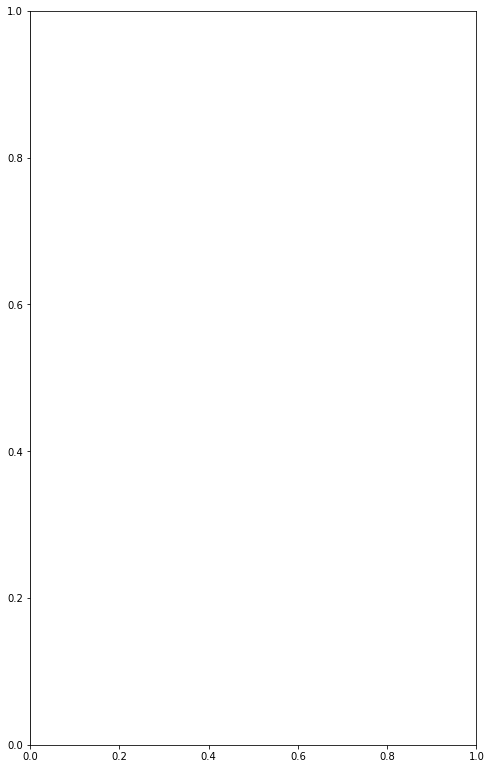

In [24]:
shap_test = shap.TreeExplainer(clf).shap_values(X_mte)
shap.summary_plot(shap_test, X_mte,
                      max_display=30, auto_size_plot=True)

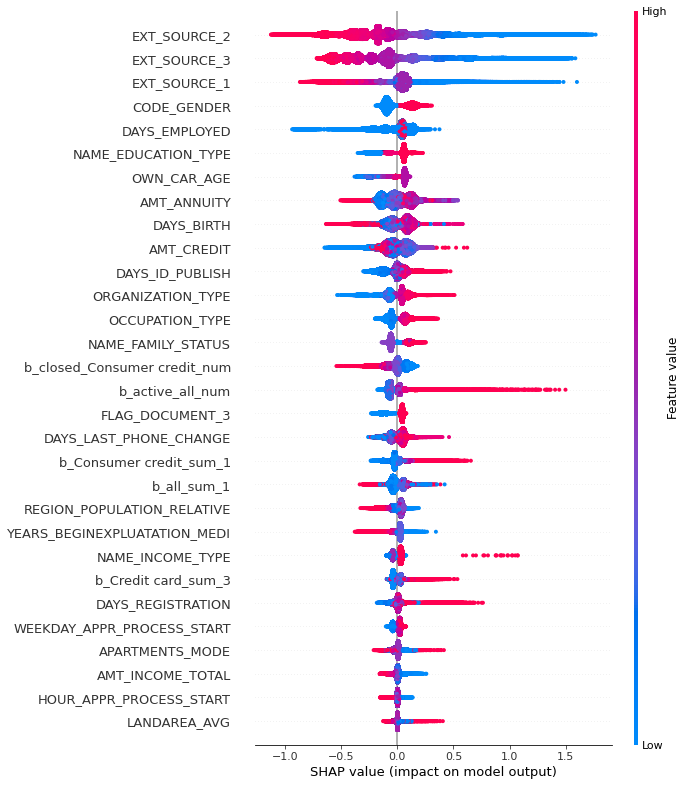

In [25]:
shap.summary_plot(shap_test, X_mte,
                      max_display=30, auto_size_plot=True)

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_mte.to_numpy(), feature_names=k1,
                                                   class_names=['bad','good'])
exp = explainer.explain_instance(X_test.loc[1], clf.predict, num_features=30)
exp.show_in_notebook(show_table=True)

ValueError: ignored

In [ ]:
explainer = LimeTabularExplainer(X.values, feature_names=X.columns, 
                                 class_names=["bad", "good"], 
                                 discretize_continuous=True,
                                 kernel_width=5)
i = 304
exp = explainer.explain_instance(X.values[i], clf.predict_proba, 
                                 num_features= 30)
exp.show_in_notebook(show_table=True, show_all=False)

ValueError: ignored

In [34]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:],  X.iloc[1,:])

Подбор гиперпараметров для RandomForest, построение модели и получение результатов

In [ ]:
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X_mte, y, test_size=0.2, random_state = 42)

    param = {
        'n_estimators' : trial.suggest_int("rf_n_estimators", 10, 1000),
        'max_depth' : trial.suggest_int("rf_max_depth", 2, 32, log=True)
    }

    model = RandomForestClassifier(**param)

    model.fit(X_mte,y)
    pred = model.predict_proba(test_mte)[:,1]
    return roc_auc_score(test_Y, pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2021-04-23 13:12:27,217] A new study created in memory with name: no-name-00c2e7b3-4437-4eaa-afc8-835faca0d4e0
[I 2021-04-23 13:17:45,622] Trial 0 finished with value: 0.7149604519753976 and parameters: {'rf_n_estimators': 101, 'rf_max_depth': 28}. Best is trial 0 with value: 0.7149604519753976.
[I 2021-04-23 13:19:28,598] Trial 1 finished with value: 0.734967719209418 and parameters: {'rf_n_estimators': 97, 'rf_max_depth': 8}. Best is trial 1 with value: 0.734967719209418.
[I 2021-04-23 13:23:39,316] Trial 2 finished with value: 0.7267872173687729 and parameters: {'rf_n_estimators': 309, 'rf_max_depth': 6}. Best is trial 1 with value: 0.734967719209418.
[I 2021-04-23 13:28:19,717] Trial 3 finished with value: 0.6951283998332911 and parameters: {'rf_n_estimators': 989, 'rf_max_depth': 2}. Best is trial 1 with value: 0.734967719209418.
[I 2021-04-23 13:30:30,176] Trial 4 finished with value: 0.7304667976266701 and parameters: {'rf_n_estimators': 64, 'rf_max_depth': 15}. Best is trial

In [ ]:
params = {'n_estimators': 516, 'max_depth': 13}
clf = RandomForestClassifier(n_estimators = 516, max_depth = 13)
clf.fit(X_mte, y)
pred = clf.predict_proba(test_mte)[:,1]
roc_auc_score(test_Y, pred)

0.740987245471075